In [55]:
from IPython.core.debugger import set_trace

import torch
import numpy as np
import torch.nn as nn

# -- for grid 2d plot
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# -- for 3d plot 
#from mpl_toolkits.mplot3d import Axes3Dx
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

# -- for models
from importlib import reload
auc_pairs={}
auc_pairs_train={}

# -- for AUC and metrics: 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp


def plot_rocs(pairs):
    for name, (fpr, tpr, roc_auc) in pairs.items(): 
        plt.plot(fpr, tpr, label = F"{name}: area {roc_auc:0.3f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
    
    plt.legend(loc="lower right")
    plt.show()





In [56]:
def logit1(x1,x2,alpha=0.1, bias = -10, c=2, w  = 0.5, a=0.25, b=1.3): #alpha=0.001
    assert (x2 >= 0).all()
    f1 = np.exp(-x1)
    f2 = b*x2 + c * np.sin(a*x2)
    cross = - alpha * x1 * x2
    return (f1 + f2 + cross + bias)*w

def prob(x1, x2, w=0.5, logit = logit1): 
    
    logits = logit(x1,x2, w=w)
    
    return 1/(1+np.exp(-logits))

In [57]:
x1_range = (-3, 5)
x2_range = (0,15)
n=500

device="cuda"#"cpu"
np.random.seed(1)

In [58]:
def plot(model,axis=None, show_=True, scoreplot = False):
    x1 = arange(*x1_range,0.1)
    x2 = arange(*x2_range,0.1)
    X1, X2 = meshgrid(x1, x2) # grid of point
    tX1 = torch.from_numpy(X1).to(device).view(-1,1).float()
    tX2 = torch.from_numpy(X2).to(device).view(-1,1).float()

    data = torch.cat([tX1,tX2], dim=1)
    
    #score = model(tX1,tX2).detach().clone().to("cpu").view(*X1.shape)
    score = model(data).detach().clone().to("cpu").view(*X1.shape)
    if scoreplot: 
        Z = score.numpy()
    else: 
        Z = 1/(1+(-score).exp()).numpy()
    
    if axis: 
        im = axis.imshow(np.flip(Z, axis = 0),cmap=cm.RdBu) # drawing the function
    else:    
        im = imshow(np.flip(Z, axis = 0),cmap=cm.RdBu) # drawing the function
    if not scoreplot: im.set_clim(0,1)
    # adding the Contour lines with labels
    #cset = contour(Z,arange(-10,150,5),linewidths=1,cmap=cm.Set2)
    #clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    colorbar(im,ax = axis) # adding the colobar on the right
    # latex fashion title
    #title('$z=(1-x_1^2+x_2^3) e^{-(x^2+y^2)/2}$')
    if show_: show()

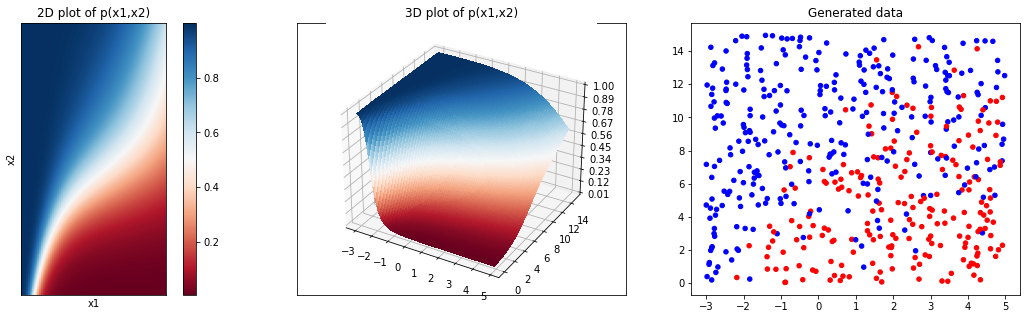

In [59]:
w= 0.5    
    
fig, axis = plt.subplots(1,3, figsize = (20,5))


x1 = arange(*x1_range,0.1)
x2 = arange(*x2_range,0.1)
X1, X2 = meshgrid(x1, x2) # grid of point
Z = prob(X1, X2,w)
im = axis[0].imshow(np.flip(Z, axis = 0),cmap=cm.RdBu) # drawing the function
fig.colorbar(im,  ax=axis[0]) # adding the colobar on the right
axis[0].set_xticks([])
axis[0].set_yticks([])
axis[0].set_xlabel("x1")
axis[0].set_ylabel("x2")
axis[0].set_title("2D plot of p(x1,x2)")

axis[1].set_xticks([])
axis[1].set_yticks([])
axis[1] = fig.add_subplot(1,3,2, projection='3d')
surf = axis[1].plot_surface(X1, X2, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

axis[1].zaxis.set_major_locator(LinearLocator(10))
axis[1].zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
axis[1].set_title("3D plot of p(x1,x2)")

#fig.colorbar(surf, shrink=0.1, aspect=5,ax=axis[1])

#data type 1: uniform x1,x2

x1 = np.random.uniform(*x1_range,n)
x2 = np.random.uniform(*x2_range,n)
p = prob(x1,x2,w)
y = torch.bernoulli(torch.from_numpy(p)).numpy()
colors = np.array(["red","blue"])[((y+1)/2).astype(int)]

axis[2].scatter(x1,x2, c = colors, s= 20)
axis[2].set_title("Generated data")
plt.show()

In [73]:
seed=1234
rd =np.random.RandomState(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [74]:
np.random.seed(1)
x1 = rd.uniform(*x1_range,n)
x2 = rd.uniform(*x2_range,n)
predictors = np.stack([x1,x2])

x1_test = rd.uniform(*x1_range,n)
x2_test = rd.uniform(*x2_range,n)
predictors_test = np.stack([x1_test,x2_test])

p = prob(x1,x2, w)
y = torch.bernoulli(torch.from_numpy(p)).numpy()

p_test = prob(x1_test,x2_test, w)
y_test = torch.bernoulli(torch.from_numpy(p_test)).numpy()

In [75]:
#nns.MonotonicNN_JK,  nns.MonotonicNN
#model_monotonic_JK =nns.MonotonicNN_JK(2, [100, 100, 100], nb_steps=500, dev=device,x0 = +x1_range[0]).to(device)
#optim_monotonic = torch.optim.Adam(model_monotonic.parameters(), 1e-3, weight_decay=1e-5)
#optim_mlp = torch.optim.Adam(model_mlp.parameters(), 1e-3, weight_decay=1e-5)

data = torch.from_numpy(predictors.transpose()).to(device).float()
target = torch.from_numpy(y).to(device).float()

data_test = torch.from_numpy(predictors_test.transpose()).to(device).float()
target_test = torch.from_numpy(y_test).to(device).float()

#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()
sigmoid = torch.nn.Sigmoid()# important!! If I use my own sigmoid, cuda error accurs..;;;

In [63]:
from xgboost import XGBClassifier
booster = XGBClassifier(max_depth = 5, use_label_encoder=False, monotone_constraints=(-1,1))

booster.fit(predictors.transpose(), (y).astype(int))


y_pred_tr = booster.predict(predictors.transpose())

predictions_tr = [round(value) for value in y_pred_tr]

# evaluate predictions

accuracy_tr = accuracy_score(y, predictions_tr)

print("Train Accuracy: %.2f%%" % (accuracy_tr * 100.0))

y_pred_test = booster.predict(predictors_test.transpose())
predictions_test = [round(value) for value in y_pred_test]
accuracy_test = accuracy_score(y_test, predictions_test)
print("Test Accuracy: %.2f%%" % (accuracy_test * 100.0))


y_pred_tr = booster.predict_proba(predictors_test.transpose())
y_scores = y_pred_tr[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
auc_pairs.update({"xgboost": (fpr, tpr, roc_auc) })

y_pred_tr = booster.predict_proba(predictors.transpose())
y_scores = y_pred_tr[:,1]
fpr, tpr, _ = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)
auc_pairs_train.update({"xgboost": (fpr, tpr, roc_auc) })

[15:52:20] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 90.20%
Test Accuracy: 88.00%


In [76]:
%load_ext autoreload
%autoreload 2
from importlib import reload
import nets
import JK_mon_general_dim as JK_mon
reload(JK_mon)
#as Jimport toy_2d_network as nets

#from mono.nets.utils import get_n_params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'mono.nets.UMNN.JK_mon_general_dim' from '/home/kim2712/Desktop/research/mono/mono/nets/UMNN/JK_mon_general_dim.py'>

In [77]:
reload(JK_mon)
#fac = 20
model_mlp = nets.basic_net(device="cuda", dim=2, z_dim=1, leaky=0.1, factor=20)


model_monotonic1 = JK_mon.mono_net(dim=2,  device="cuda",   mon=[-1,+1])
model_monotonic2 = JK_mon.mono_net(dim=2,  device="cuda",   mon=[-1,+1])
model_monotonic3 = JK_mon.mono_net(dim=2,  device="cuda",   mon=[-1,+1])
model_monotonic4 = JK_mon.mono_net(dim=2,  device="cuda",   mon=[-1,+1])


models = {"mlp":model_mlp,
          "mono_c":model_monotonic1,
          "mono_g":model_monotonic2,
          "mono_c_pen":model_monotonic3,
          "mono_g_pen":model_monotonic4}
#optims = {key: torch.optim.Adam(model.parameters(), 1e-2, weight_decay=0.01) for key, model in models.items()}
optims = {key: torch.optim.Adam(model.parameters(), 1e-2) for key, model in models.items()}
schedulers = {key:torch.optim.lr_scheduler.ExponentialLR(optims[key], gamma=0.9999) for key, model in models.items()}

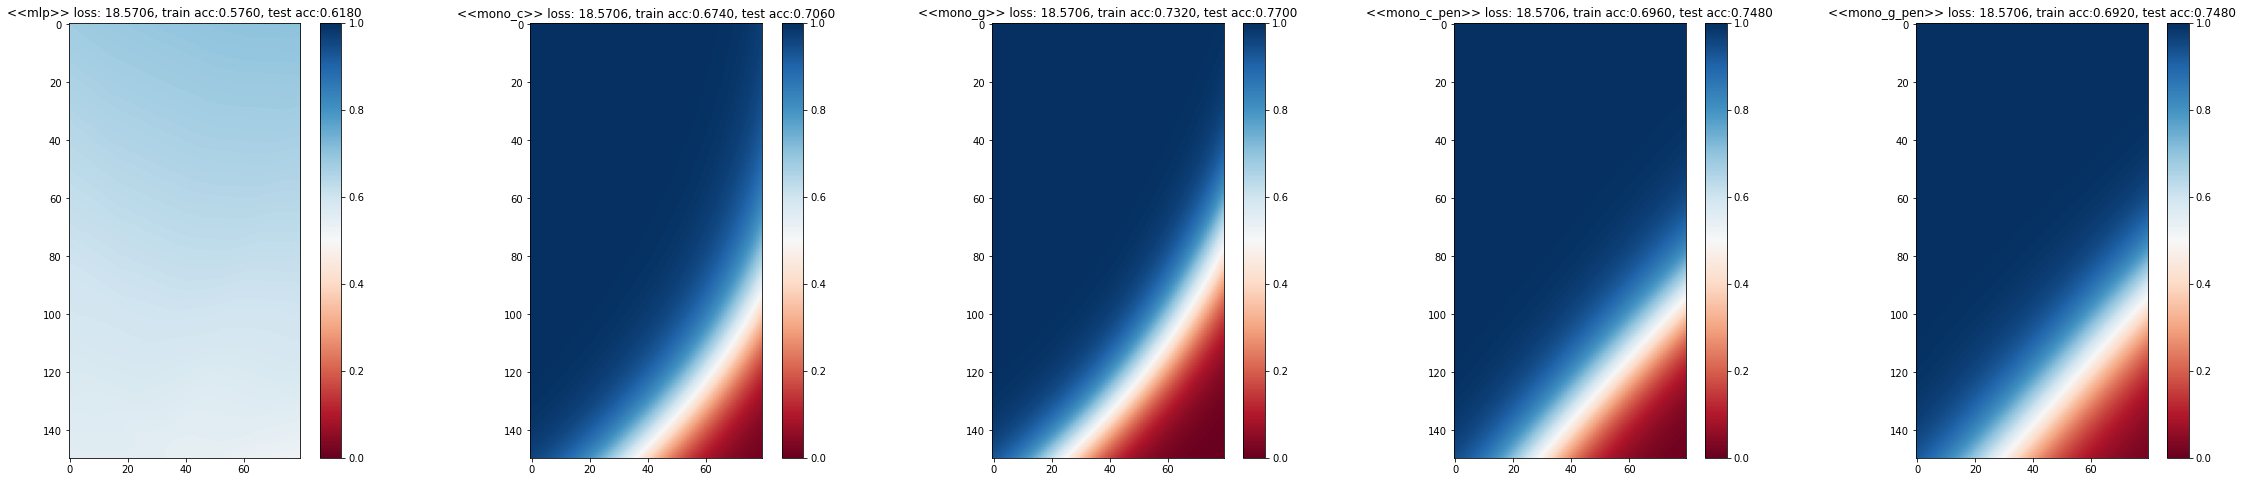

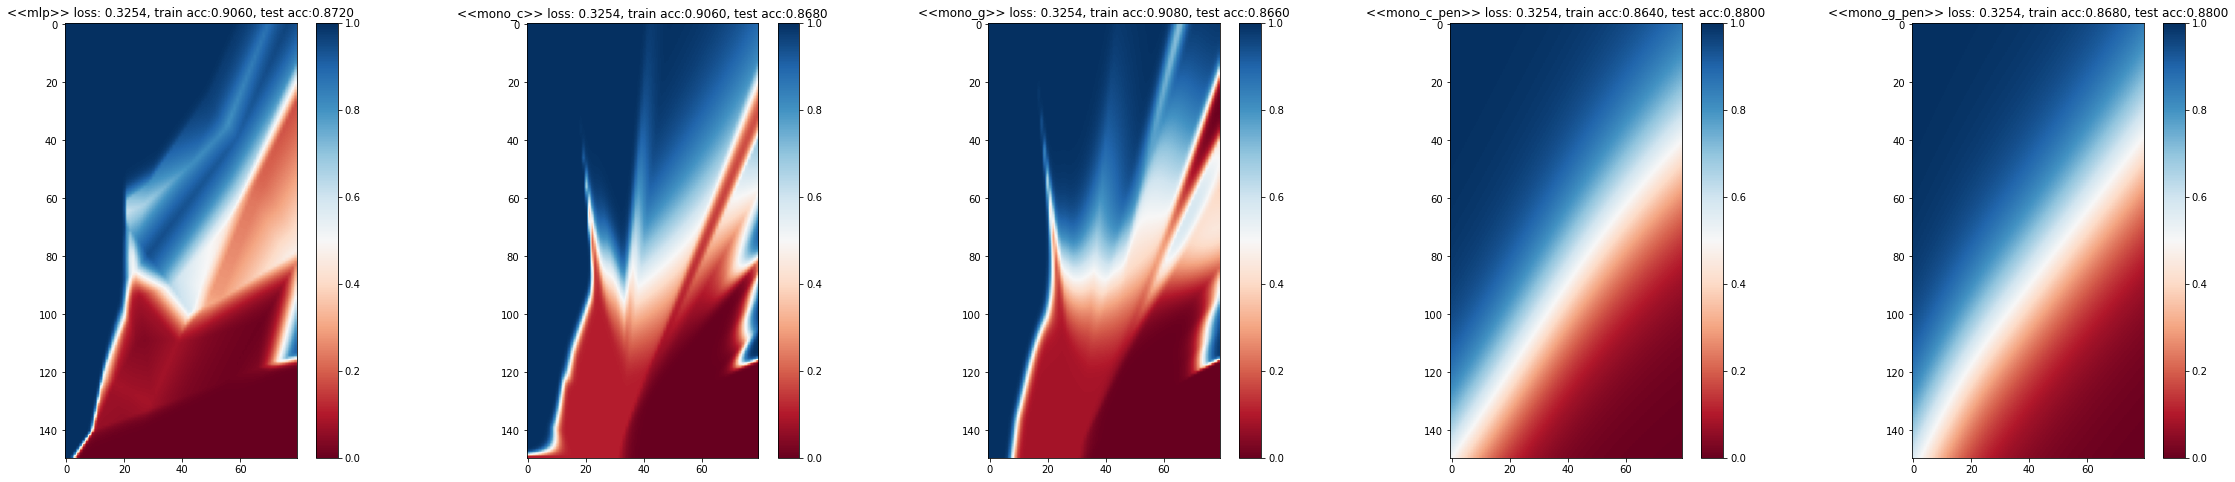

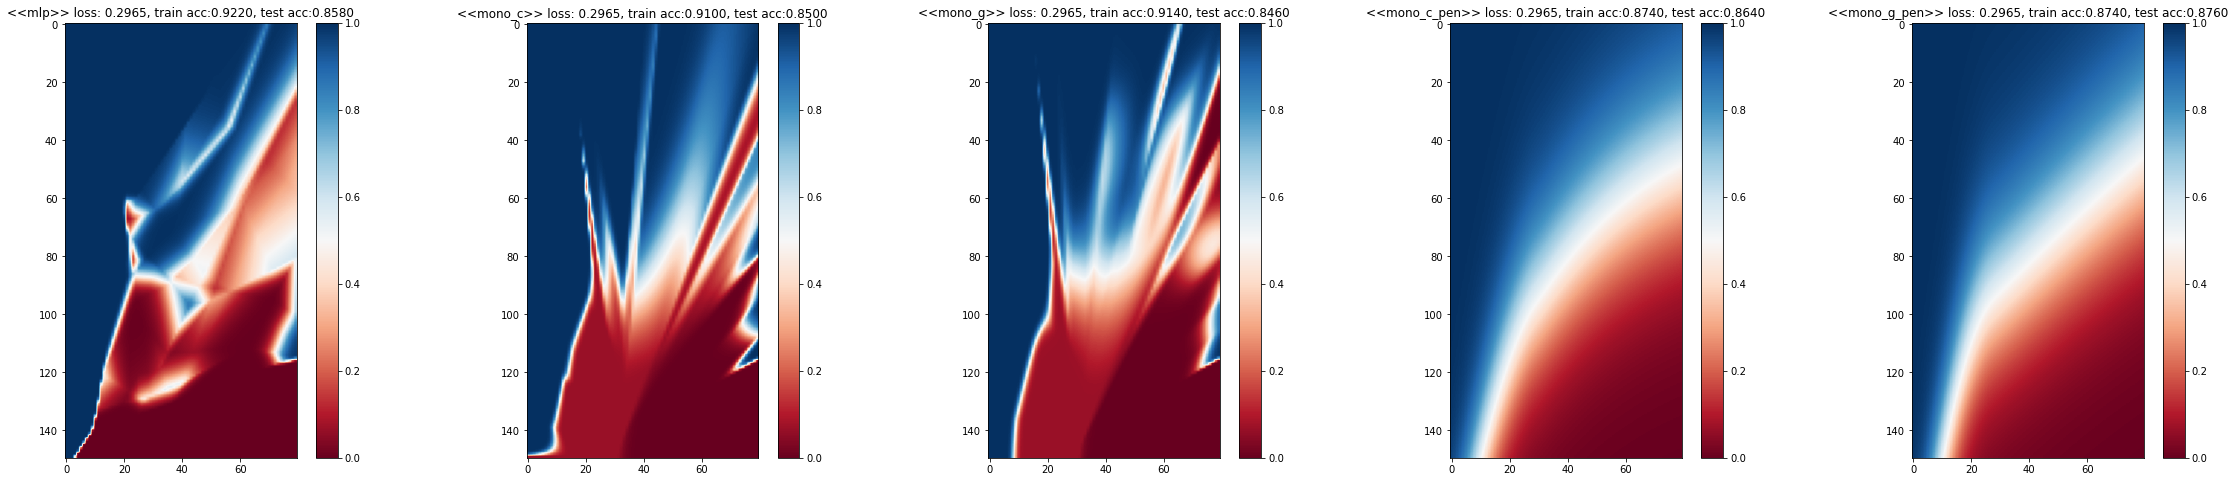

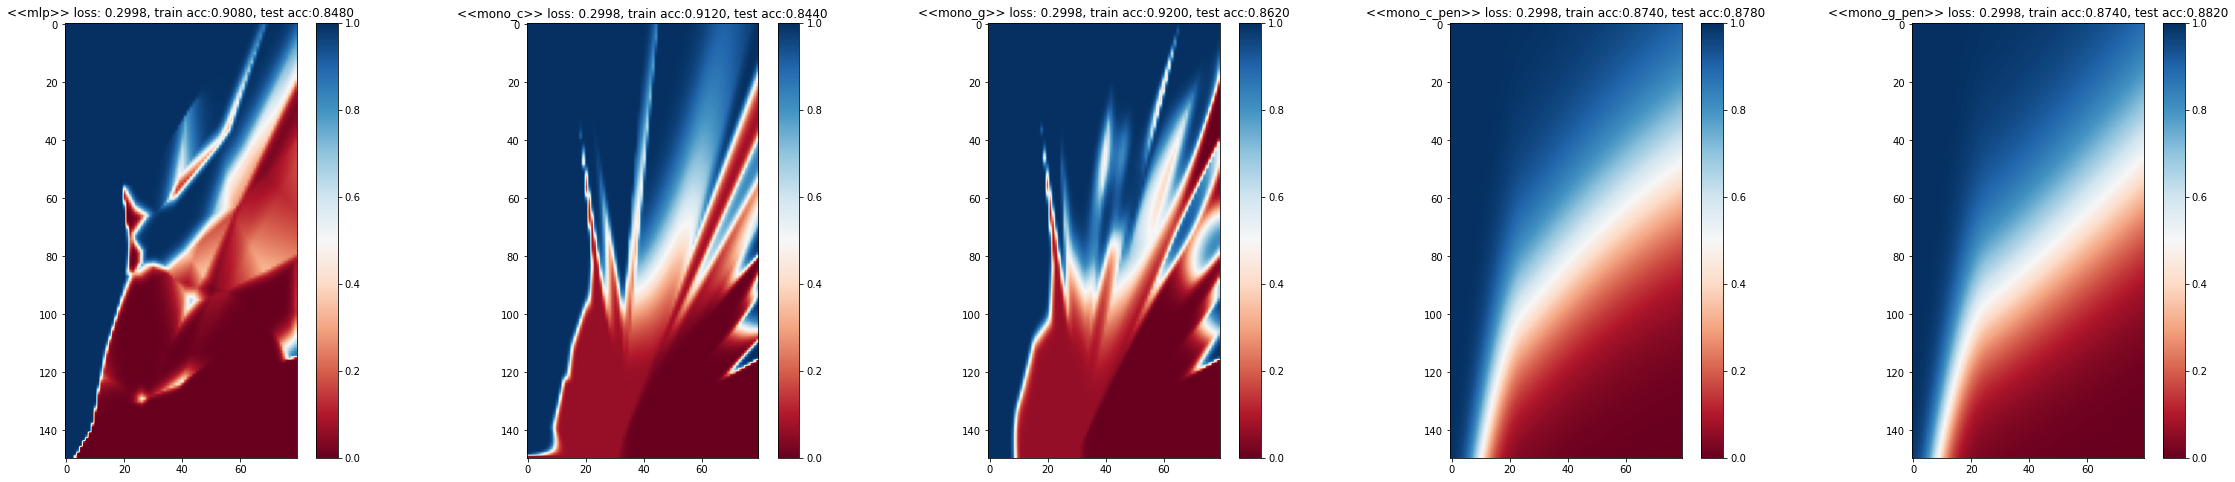

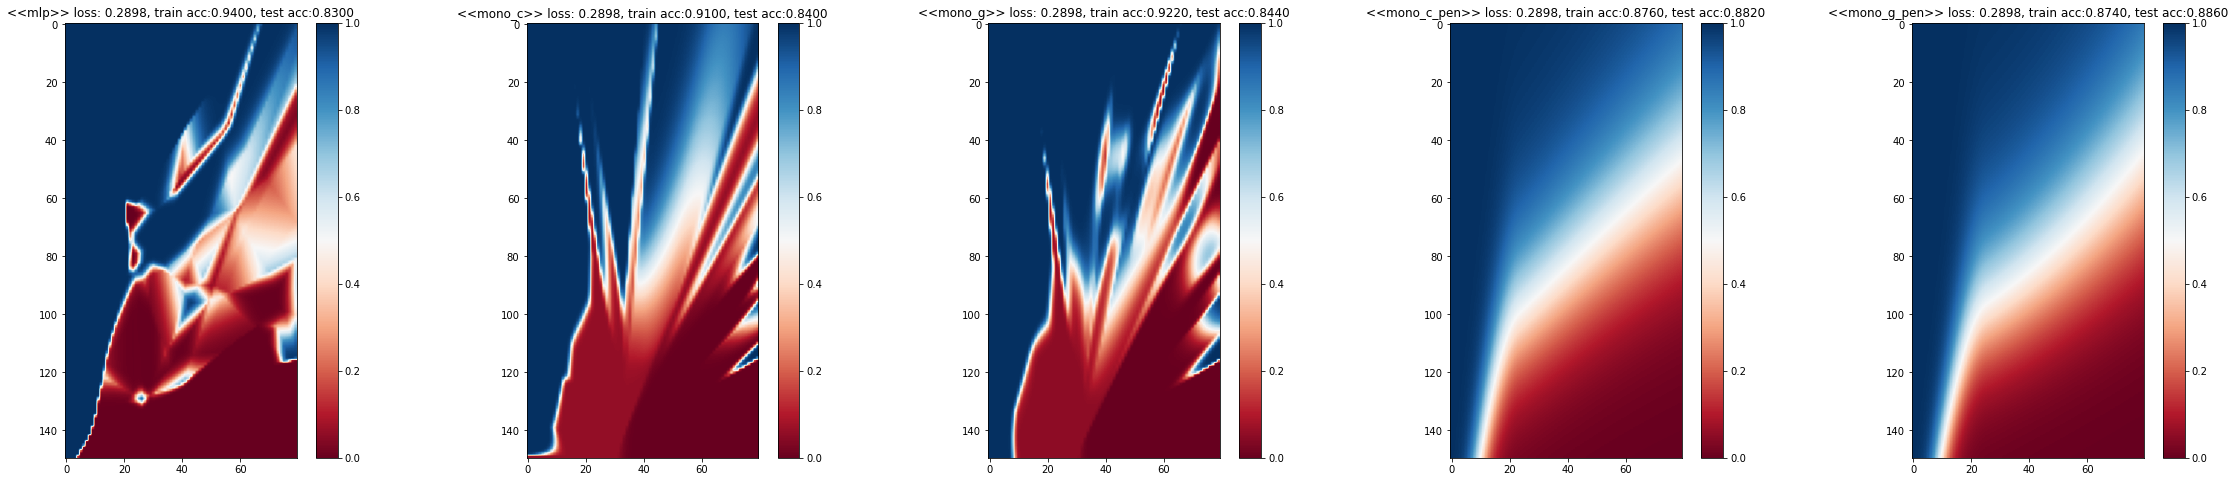

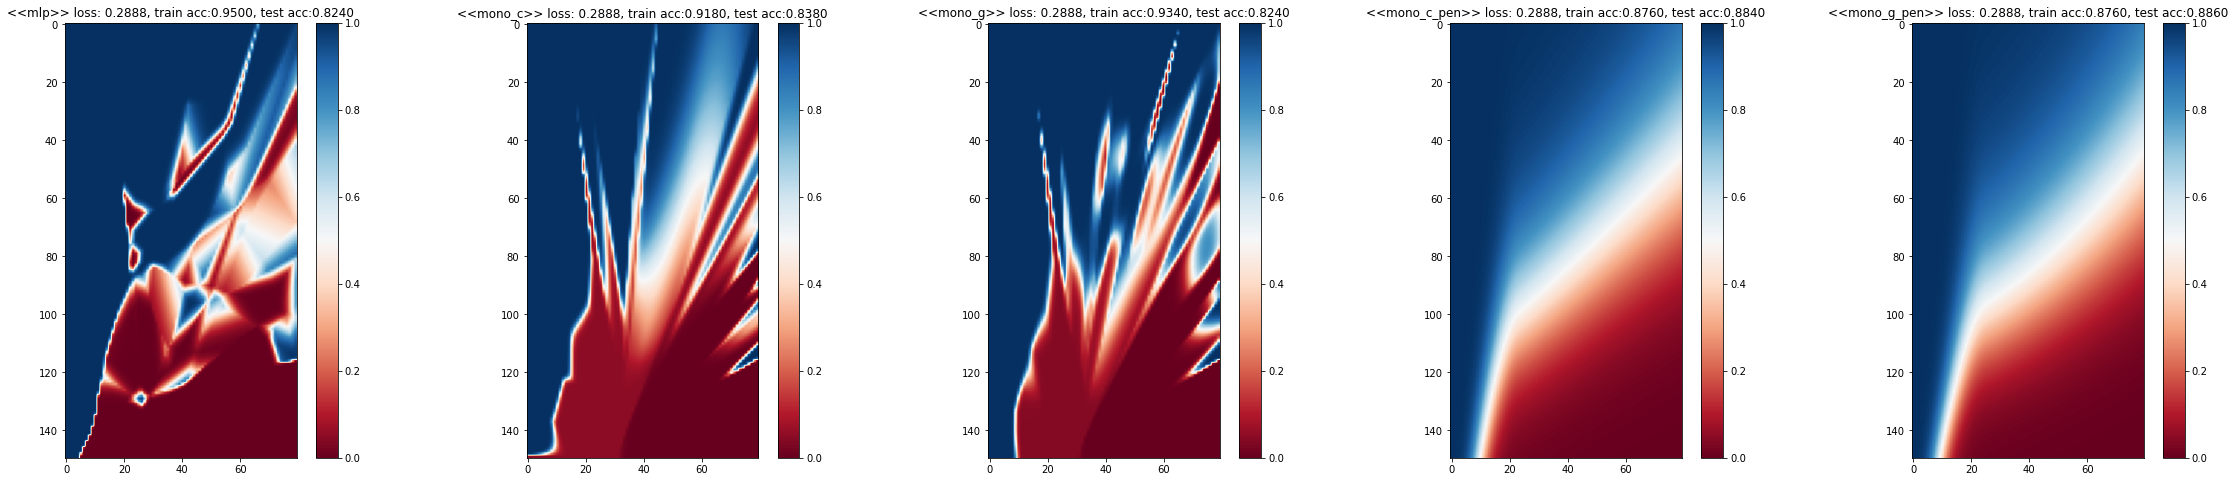

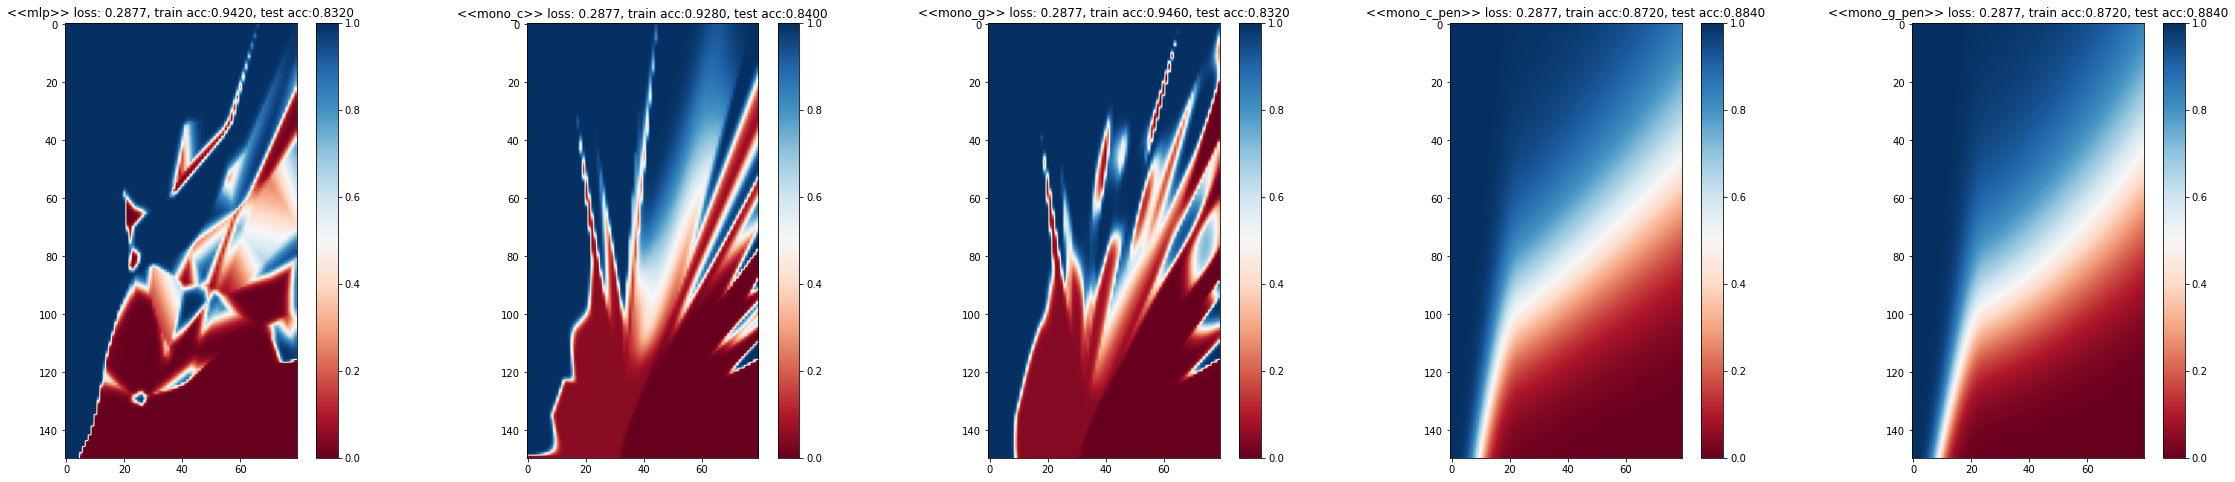

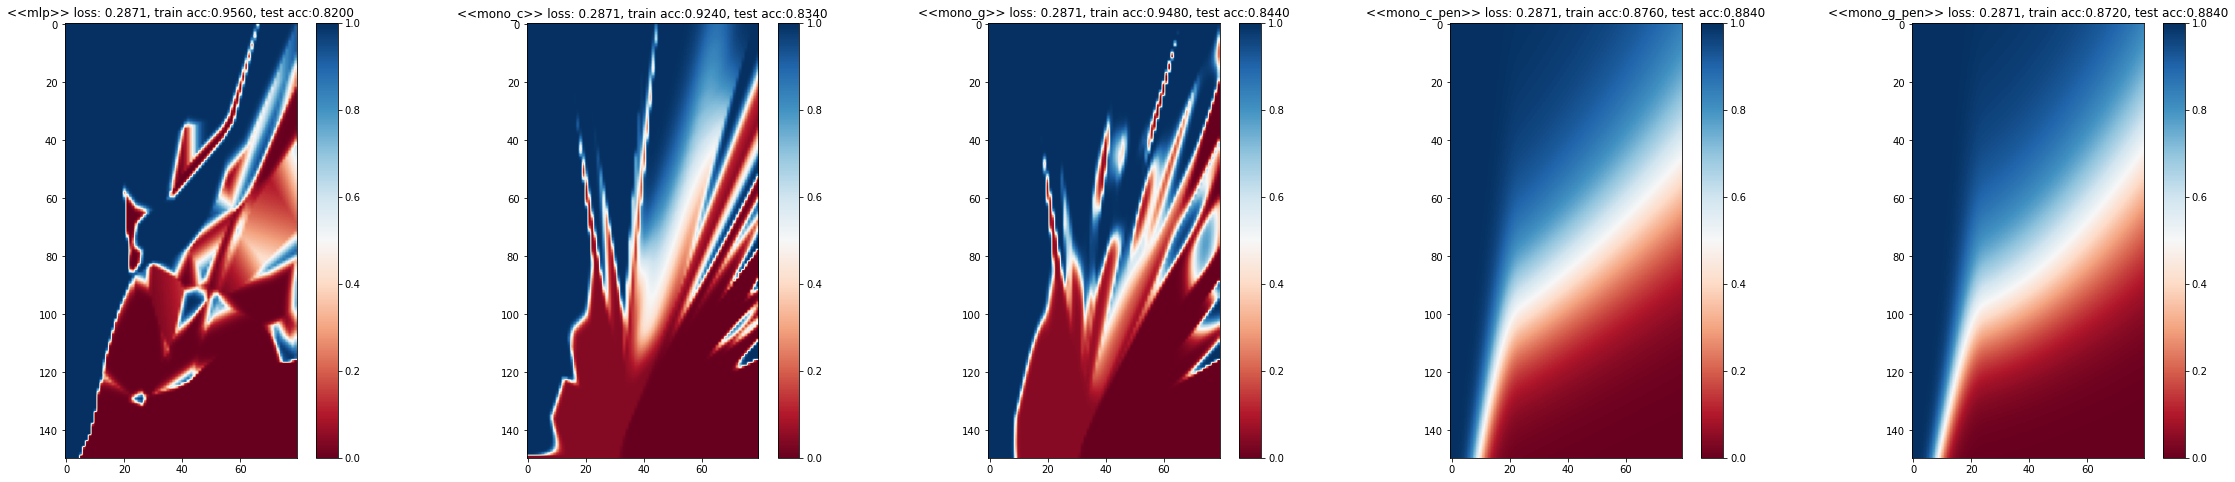

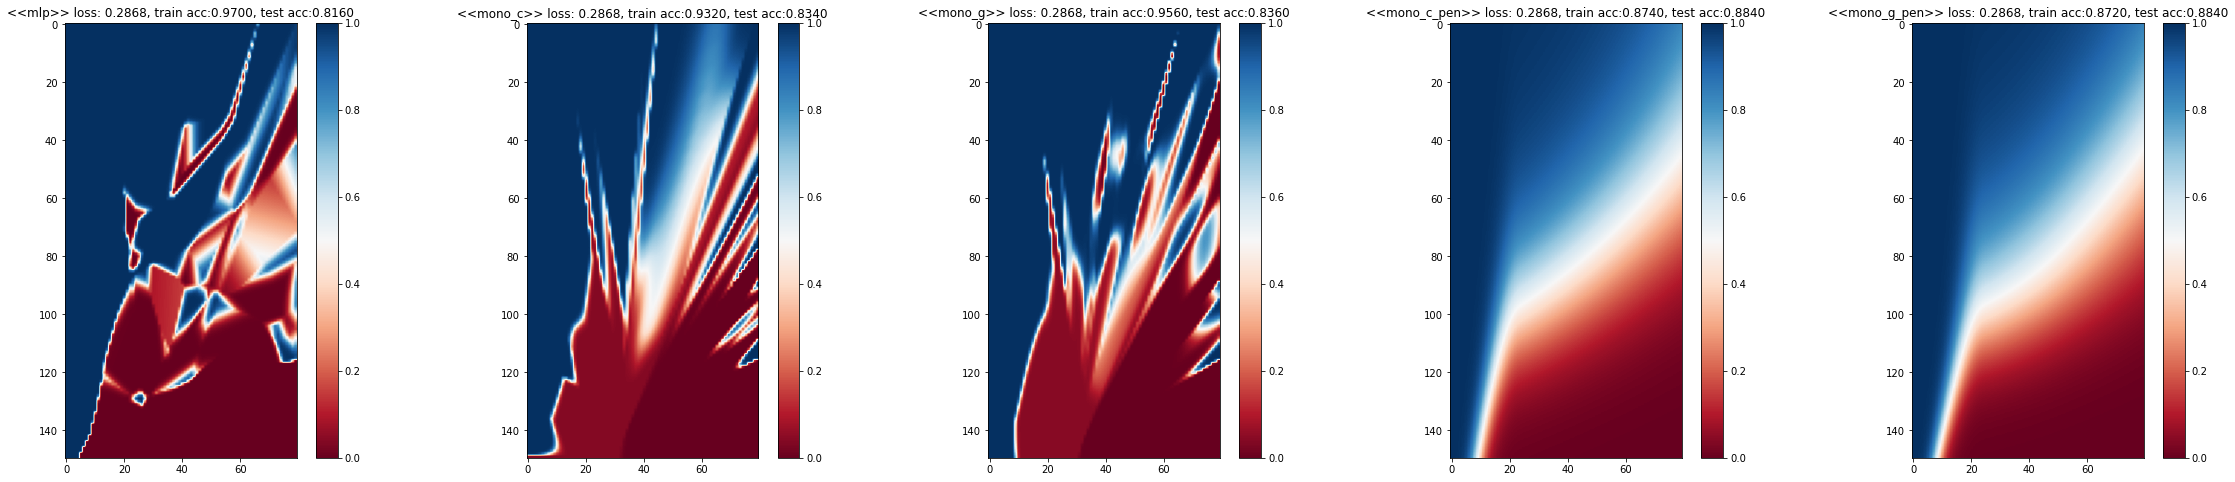

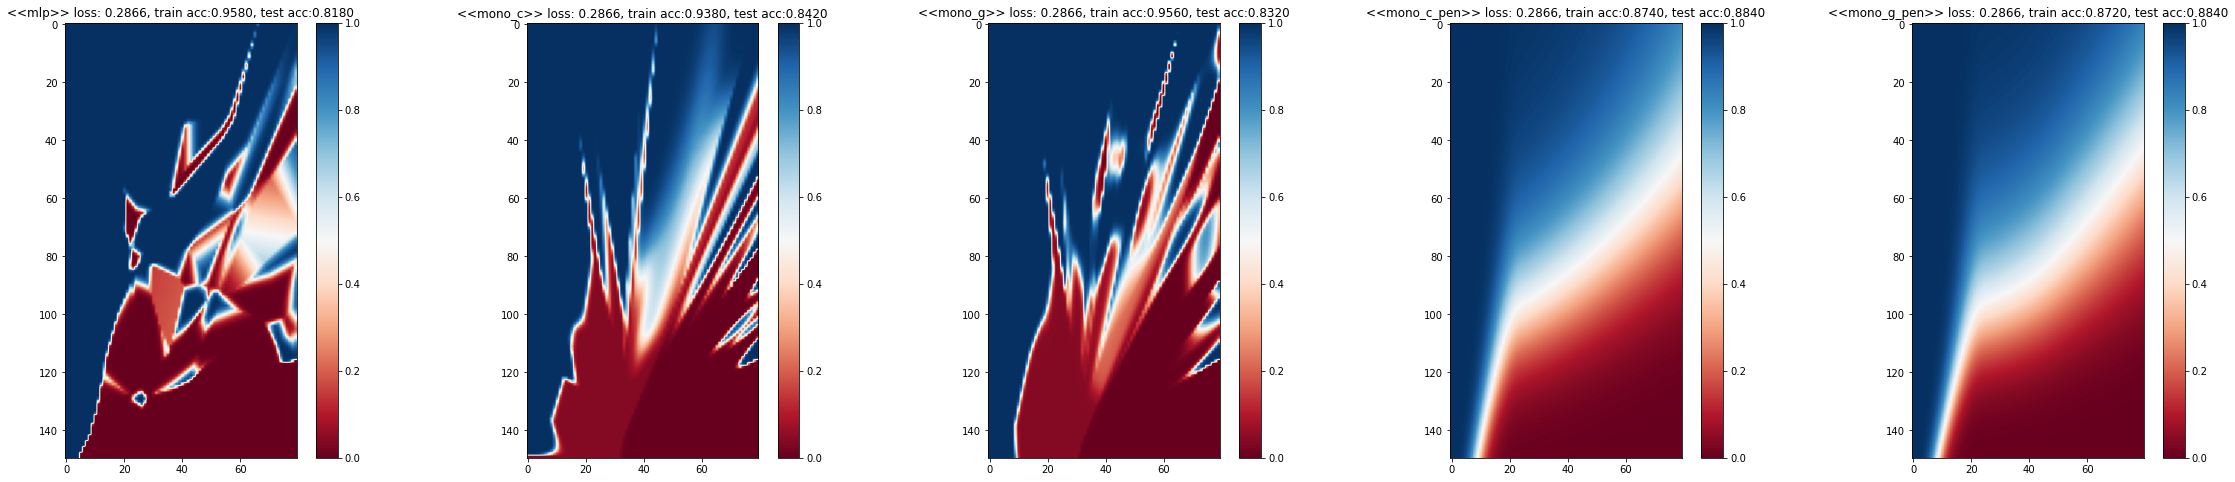

In [78]:
bs = 500 #50
weight = 0

data.requires_grad = True
for it in range(10000):
    
    for m, (name, model) in enumerate(models.items()):
        
        optim = optims[name]
        scheduler =schedulers[name]
        for i in range(1):#(10):
            data_ = data[i*bs:(i+1)*bs]
            quadrature="clenshaw" if "c" in name else "gaussian"
            if name == "mlp":
                output = model(data[i*bs:(i+1)*bs])
            else:
                output, grad = model(data[i*bs:(i+1)*bs], return_grad=True, quadrature=quadrature)
            score  = output.view(-1)
            probs = sigmoid(score)
            loss = criterion(probs, target[i*bs:(i+1)*bs])
            if "pen" in name:
                loss += 1.0 * model.penalty(*grad, X=data_)

            optim.zero_grad()
            loss.backward()
            optim.step()
            scheduler.step()
    if it%1000 == 0: 
        fig, axis = plt.subplots(1,5, figsize = (40, 8))
        with torch.no_grad(): 
            for m, (name, model) in enumerate(models.items()):
                ax = axis[m]

                plot(model, axis = ax, show_=False)

                #score_test = model(data_test[:,0:1],data_test[:,1:]).view(-1)
                score_test = model(data_test).view(-1)
                predict_test = (score_test>0).int()
                accuracy_test = (target_test==predict_test).float().mean().item()

                #score = model(data[:,0:1],data[:,1:]).view(-1)
                score = model(data).view(-1)
                predict = (score>0).int()
                accuracy = (target==predict).float().mean().item()

                ax.set_title(F"<<{name}>> loss: {loss.item():.4f}, train acc:{accuracy:.4f}, test acc:{accuracy_test:.4f}")
        plt.show()

In [79]:
def line_ev(model, x1):
    
    
    return(fs)

def line_ev2(model, x2):
    
    fs = {}
    for knot in [-2,0,1,3]:
        x1 = 0 * x2 + knot
        data = torch.from_numpy(np.stack([x1,x2]).transpose()).to(device).float()
        f = model(data[:,0:1],data[:,1:])
        if isinstance(f,torch.Tensor):
            f = f.detach().cpu().numpy()
        fs.update({knot:f})
    return(fs)

                   
def mono(x1,x2): 
    return sigmoid(model_monotonic(torch.cat([x1,x2], dim=1)))

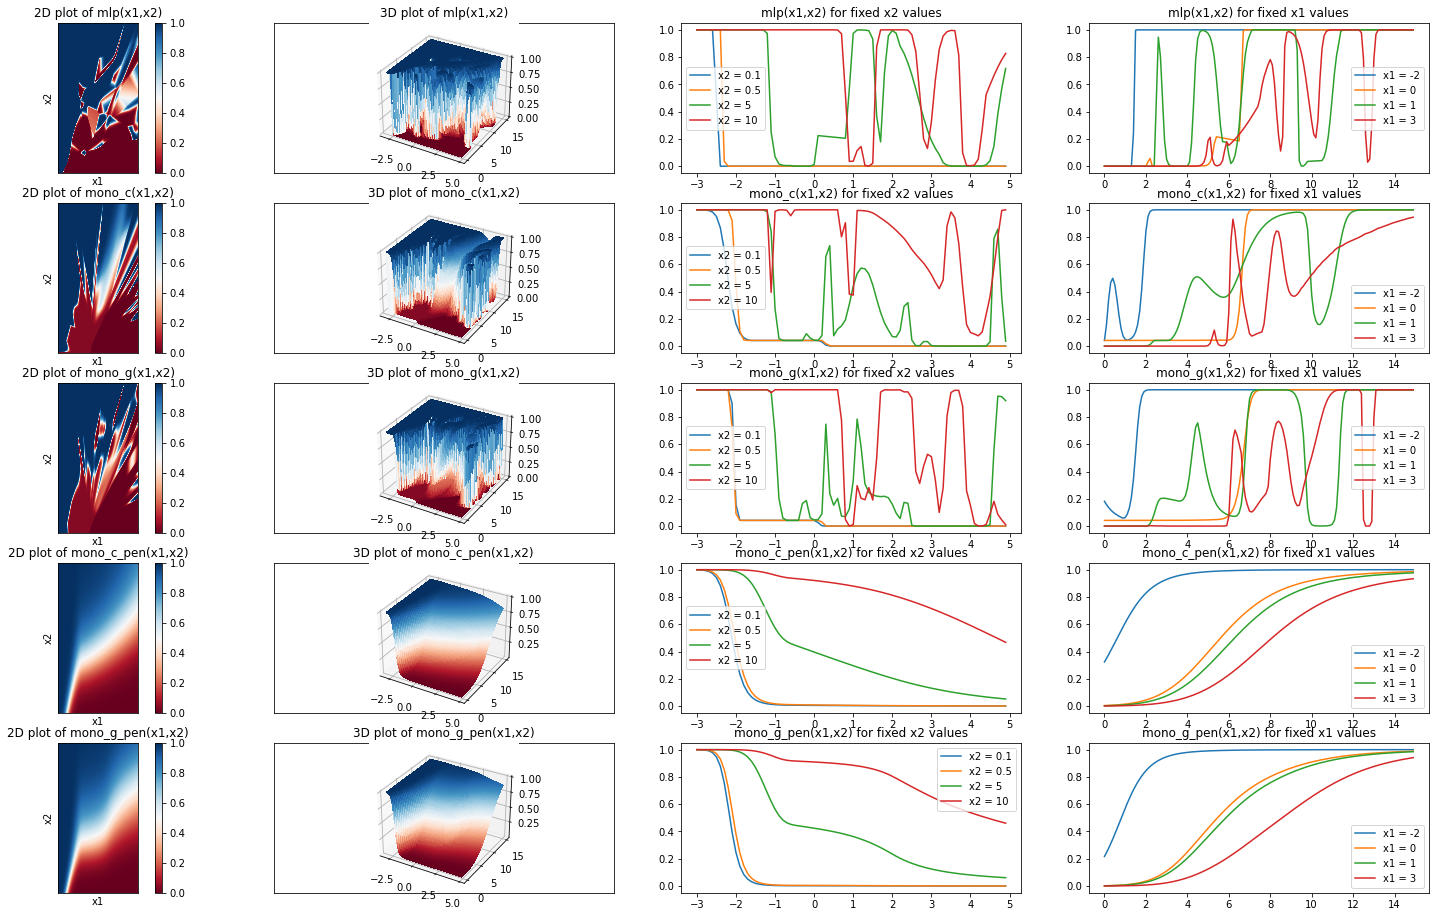

In [80]:
figs, axis = plt.subplots(5,4, figsize = (28, 16))

for i, (name, model) in enumerate(models.items()):
    

    ax = axis[i,2]
    ax.set_title(F"{name}(x1,x2) for fixed x2 values")
    x1 = arange(*x1_range,0.1)
    x2 = arange(*x2_range,0.1)
    
    fs = {}
    for knot in [0.1, 0.5, 5, 10]:
        x2 = 0 * x1 + knot
        data = torch.from_numpy(np.stack([x1,x2]).transpose()).to(device).float()
        f = sigmoid(model(data))
        if isinstance(f,torch.Tensor):
            f = f.detach().cpu().numpy()
        fs.update({knot:f})
        
    for knot,f in fs.items():
        ax.plot(x1,f, label = F"x2 = {knot}")
    ax.legend()
    
    ax = axis[i,3]
    ax.set_title(F"{name}(x1,x2) for fixed x1 values")
    x1 = arange(*x1_range,0.1)
    x2 = arange(*x2_range,0.1)
    fs2 = {}
    for knot in [-2,0,1,3]:
        x1 = 0 * x2 + knot
        data = torch.from_numpy(np.stack([x1,x2]).transpose()).to(device).float()
        f = sigmoid(model(data))
        if isinstance(f,torch.Tensor):
            f = f.detach().cpu().numpy()
        fs2.update({knot:f})

    for knot,f in fs2.items():
        ax.plot(x2,f, label = F"x1 = {knot}")
    ax.legend()
    
    
    x1 = arange(*x1_range,0.1)
    x2 = arange(*x2_range,0.1)
    X1, X2 = meshgrid(x1, x2) # grid of point
    D = torch.cat([torch.from_numpy(X1).to(device).float().view(-1,1), torch.from_numpy(X2).to(device).float().view(-1,1)],dim=1)
    Z = sigmoid(model(D))
    Z = Z.view(*X1.shape).detach().cpu().numpy()
    im = axis[i,0].imshow(np.flip(Z, axis = 0),cmap=cm.RdBu) # drawing the function
    
    colorbar(im,ax = axis[i,0])
    im.set_clim(0,1)
    
    axis[i,0].set_xticks([])
    axis[i,0].set_yticks([])
    axis[i,0].set_xlabel("x1")
    axis[i,0].set_ylabel("x2")
    axis[i,0].set_title(F"2D plot of {name}(x1,x2)")
    
    
    axis[i,1].set_xticks([])
    axis[i,1].set_yticks([])
    axis[i,1] = figs.add_subplot(5,4,(i+1)*4-2, projection='3d')
    surf = axis[i,1].plot_surface(X1, X2, Z, rstride=1, cstride=1, 
                          cmap=cm.RdBu,linewidth=0, antialiased=False)

#    axis[i,1].zaxis.set_major_locator(LinearLocator(10))
#    axis[i,1].zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    axis[i,1].set_title(F"3D plot of {name}(x1,x2)")
    
    #fig.colorbar(surf, shrink=0.1, aspect=5,ax=axis[1])

    
plt.show()

In [81]:
data = torch.from_numpy(predictors.transpose()).to(device).float()
target = torch.from_numpy(y).to(device).float()

data_test = torch.from_numpy(predictors_test.transpose()).to(device).float()
target_test = torch.from_numpy(y_test).to(device).float()

#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()
sigmoid = torch.nn.Sigmoid()# important!! If I use my own sigmoid, cuda error accurs..;;;



with torch.no_grad():
    for m, (name, model) in enumerate(models.items()):
        out= model(data_test)
        y_scores = 1/(1+(-out).exp())
        fpr, tpr, _ = roc_curve(y_test, y_scores.cpu())
        roc_auc = auc(fpr, tpr)
        auc_pairs.update({name: (fpr, tpr, roc_auc) })
        
        
        out= model(data)
        y_scores = 1/(1+(-out).exp())
        fpr, tpr, _ = roc_curve(y, y_scores.cpu())
        roc_auc = auc(fpr, tpr)
        auc_pairs_train.update({name: (fpr, tpr, roc_auc) })

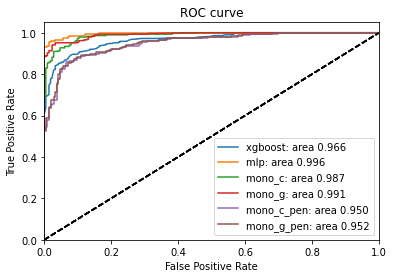

In [82]:
plot_rocs(auc_pairs_train)

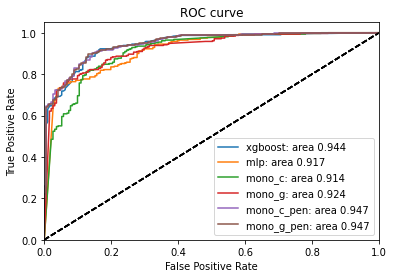

In [83]:
plot_rocs(auc_pairs)